## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp
from tqdm import tqdm
import glob
import xarray as xr

from fair import *

%matplotlib inline

# DECK simulations
In this notebook, we run FaIRv2 simulations for the abrupt-4xCO2 & 1pctCO2 CMIP6 experiments.

### Generate parameter set
Here we generate parameter sets of 50,000 members each for the FULL and CONSTRAINED ensembles.

In [2]:
## choose the datasets to use here:
datasets_to_use = ['HadCRUT5','HadCRUT4','NOAA','GISTEMP','CW','BERKELEY']

FULL_probabilities = pd.concat([pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/FULL_selection_probability-'+x+'.h5') for x in datasets_to_use],axis=1,keys=datasets_to_use)
FULL_ensemble_selection = FULL_probabilities.mean(axis=1)>np.random.random(FULL_probabilities.shape[0])

In [3]:
N_sets = 50000

# here we randomly select which ensemble members will make up our parameter sets
FULL_ensemble_members = FULL_ensemble_selection.index[np.random.choice(FULL_ensemble_selection.size,N_sets,replace=False)]
CONSTRAINED_ensemble_members = FULL_ensemble_selection.index[FULL_ensemble_selection][np.random.choice(FULL_ensemble_selection.sum(),N_sets,replace=False)]

In [4]:
ALL_mems = [x.split('/')[-1].split('.')[0] for x in glob.glob('../../aux/parameter-sets/perturbed-parameters/gas_params/*.h5')]

FULL_thermal_set = []
FULL_gas_set = []
CONSTRAINED_thermal_set = []
CONSTRAINED_gas_set = []

## and here we generate the parameter sets
for mem_range in ALL_mems:
    
    gas_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/gas_params/'+mem_range+'.h5').loc[:,(slice(None),'carbon_dioxide')]
    thermal_params = pd.read_hdf('../../aux/parameter-sets/perturbed-parameters/climresp_params/FULL/'+mem_range+'.h5')
    
    FULL_mems = set(gas_params.columns.levels[0]).intersection(FULL_ensemble_members)
    CONSTRAINED_mems = set(gas_params.columns.levels[0]).intersection(CONSTRAINED_ensemble_members)
    
    FULL_thermal_set += [thermal_params.reindex(FULL_mems,axis=1,level=0)]
    FULL_gas_set += [gas_params.reindex(FULL_mems,axis=1,level=0)]
    CONSTRAINED_thermal_set += [thermal_params.reindex(CONSTRAINED_mems,axis=1,level=0)]
    CONSTRAINED_gas_set += [gas_params.reindex(CONSTRAINED_mems,axis=1,level=0)]
    
FULL_thermal_set = pd.concat(FULL_thermal_set,axis=1)
FULL_gas_set = pd.concat(FULL_gas_set,axis=1)
CONSTRAINED_thermal_set = pd.concat(CONSTRAINED_thermal_set,axis=1)
CONSTRAINED_gas_set = pd.concat(CONSTRAINED_gas_set,axis=1)

In [5]:
## we adjust the Pre-industrial concentration within FaIR to reflect that these experiments are begun at levels representative of 1850
FULL_gas_set.loc['PI_conc'] = 284
CONSTRAINED_gas_set.loc['PI_conc'] = 284

### Generate scenarios
Here we only need to create two scenarios: one where the CO2 concentration increases by 1 % per year; and one where the CO2 concentration abruptly quadruples at the start of the run.

In [6]:
DECK_experiments = pd.DataFrame(index=np.arange(201),columns=pd.MultiIndex.from_product([['1pctCO2','abrupt-4xCO2'],['carbon_dioxide']]))

DECK_experiments[('1pctCO2','carbon_dioxide')] = 284*1.01**np.arange(201)
DECK_experiments[('abrupt-4xCO2','carbon_dioxide')] = 284*4
DECK_experiments.loc[0,('abrupt-4xCO2','carbon_dioxide')] = 284

## Run the experiments

In [7]:
FULL_DECK_runs = run_FaIR(concentrations_in=DECK_experiments,
                          gas_parameters=FULL_gas_set,
                          thermal_parameters=FULL_thermal_set)

CONSTRAINED_DECK_runs = run_FaIR(concentrations_in=DECK_experiments,
                                 gas_parameters=CONSTRAINED_gas_set,
                                 thermal_parameters=CONSTRAINED_thermal_set)

## also carry out a BGC run
BGC_CONSTRAINED_gas_set = CONSTRAINED_gas_set.copy()
BGC_CONSTRAINED_gas_set.loc['rT'] = 0

BGC_FULL_gas_set = FULL_gas_set.copy()
BGC_FULL_gas_set.loc['rT'] = 0

BGC_FULL_DECK_runs = run_FaIR(concentrations_in=DECK_experiments,
                              gas_parameters=BGC_FULL_gas_set,
                              thermal_parameters=FULL_thermal_set)

BGC_CONSTRAINED_DECK_runs = run_FaIR(concentrations_in=DECK_experiments,
                                     gas_parameters=BGC_CONSTRAINED_gas_set,
                                     thermal_parameters=CONSTRAINED_thermal_set)

Integrating 2 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 200...


100%|██████████| 200/200 [00:09<00:00, 20.08 timestep/s]


Integrating 2 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 200...


100%|██████████| 200/200 [00:09<00:00, 20.07 timestep/s]


Integrating 2 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 200...


100%|██████████| 200/200 [00:09<00:00, 20.05 timestep/s]


Integrating 2 scenarios, 50000 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 200...


100%|██████████| 200/200 [00:09<00:00, 20.04 timestep/s]


In [8]:
for key in ['Emissions','C','T']:
    FULL_DECK_runs[key].drop(0,inplace=True)
    FULL_DECK_runs[key].index = np.arange(200)
    CONSTRAINED_DECK_runs[key].drop(0,inplace=True)
    CONSTRAINED_DECK_runs[key].index = np.arange(200)
    BGC_FULL_DECK_runs[key].drop(0,inplace=True)
    BGC_FULL_DECK_runs[key].index = np.arange(200)
    BGC_CONSTRAINED_DECK_runs[key].drop(0,inplace=True)
    BGC_CONSTRAINED_DECK_runs[key].index = np.arange(200)

reindex the 1pctCO2 run on emissions for a TCRE plot

In [9]:
CONSTRAINED_1pct_T = CONSTRAINED_DECK_runs['T']['1pctCO2']
CONSTRAINED_1pct_E = CONSTRAINED_DECK_runs['Emissions']['1pctCO2'].xs('carbon_dioxide',axis=1,level=1)
FULL_1pct_T = FULL_DECK_runs['T']['1pctCO2']
FULL_1pct_E = FULL_DECK_runs['Emissions']['1pctCO2'].xs('carbon_dioxide',axis=1,level=1)

BGC_CONSTRAINED_1pct_T = BGC_CONSTRAINED_DECK_runs['T']['1pctCO2']
BGC_CONSTRAINED_1pct_E = BGC_CONSTRAINED_DECK_runs['Emissions']['1pctCO2'].xs('carbon_dioxide',axis=1,level=1)
BGC_FULL_1pct_T = BGC_FULL_DECK_runs['T']['1pctCO2']
BGC_FULL_1pct_E = BGC_FULL_DECK_runs['Emissions']['1pctCO2'].xs('carbon_dioxide',axis=1,level=1)

In [10]:
def reindex_on_cum_emms(T,E):
    T.index = E
    T = T.reindex(np.concatenate([T.index,np.arange(0,5001,10)])).sort_index()
    T.loc[0] = 0
    T = T.interpolate().reindex(np.arange(0,5001,10))
    return T

In [11]:
CONSTRAINED_1pct_T_on_E = CONSTRAINED_1pct_T.apply(lambda x: reindex_on_cum_emms(x,CONSTRAINED_1pct_E[x.name].cumsum()))
FULL_1pct_T_on_E = FULL_1pct_T.apply(lambda x: reindex_on_cum_emms(x,FULL_1pct_E[x.name].cumsum()))

BGC_CONSTRAINED_1pct_T_on_E = BGC_CONSTRAINED_1pct_T.apply(lambda x: reindex_on_cum_emms(x,BGC_CONSTRAINED_1pct_E[x.name].cumsum()))
BGC_FULL_1pct_T_on_E = BGC_FULL_1pct_T.apply(lambda x: reindex_on_cum_emms(x,BGC_FULL_1pct_E[x.name].cumsum()))

### Load some CMIP6 data for comparison

You may notice this code is directly copied from the CMIP6 parameter tuning notebooks...

In [12]:
CMIP6_input_data = xr.open_dataset('../../aux/input-data/CMIP6/CMIP6_tuning_data.nc')
CMIP6_input_data = CMIP6_input_data.sel(scenario=['abrupt-4xCO2','1pctCO2']).mean('member_id').stack(index=['scenario','climate_model']).tas.to_pandas().dropna(axis=1,how='all')

## Import Arora (2020) data

fnames = ['../../aux/input-data/_hidden/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/JAMSTEC/JAMSTEC_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/IPSL/IPSL_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/IPSL/IPSL_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/IPSL/IPSL_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/IPSL/IPSL_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CanESM5/CanESM5_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CanESM5/CanESM5_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CanESM5/CanESM5_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CanESM5/CanESM5_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/GFDL/GFDL_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/GFDL/GFDL_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/GFDL/GFDL_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/GFDL/GFDL_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/MPIESM/MPIESM_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/MPIESM/MPIESM_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/MPIESM/MPIESM_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/MPIESM/MPIESM_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CESM2/CESM2_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CESM2/CESM2_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CESM2/CESM2_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/CESM2/CESM2_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/UKESM/UKESM_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/UKESM/UKESM_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/UKESM/UKESM_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/UKESM/UKESM_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/BCC/BCC_1pc_COU.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/BCC/BCC_1pc_BGC.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/BCC/BCC_1pc_RAD.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/BCC/BCC_PI_CONTROL.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/NorESM2LM/NorESM2LM_PI_CONTROL_v2.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_BGC_v2.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_RAD_v2.txt',
 '../../aux/input-data/_hidden/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_COU_v2.txt']

def get_C4MIP_data(x):
    if x == '../../aux/input-data/_hidden/model_output_cmip6/UKESM/UKESM_PI_CONTROL.txt':
        return pd.read_csv(x,delim_whitespace=True,index_col=0,skiprows=1,names=['year','ST','CO2','LA_CO2_FLUX','OA_CO2_FLUX','GPP','NPP','HETRES','CLIVE','CDEAD'])
    else:
        return pd.read_csv(x,delim_whitespace=True,index_col=0)
    
C4MIP_data = pd.concat([get_C4MIP_data(x) for x in fnames],axis=1,keys=['.'.join(x.split('/')[-1].split('.')[0:-1]) for x in fnames]).astype(float)

map_models = dict(zip(['JAMSTEC','ACCESS-ESM1.5','CNRM-ESM2.1','IPSL','CanESM5','GFDL','MPIESM','CESM2','UKESM','BCC','NorESM2LM'],\
                   ['MIROC-ES2L','ACCESS-ESM1-5','CNRM-ESM2-1','IPSL-CM6A-LR','CanESM5','GFDL-ESM4','MPI-ESM1-2-LR','CESM2','UKESM1-0-LL','BCC-CSM2-MR','NorESM2-LM']))

map_exp = dict(zip(['COU','BGC','RAD','CONTROL'],['1pctCO2','1pctCO2-bgc','1pctCO2-rad','piControl']))

map_flux_direction = dict(zip(map_models.keys(),[1,-1,1,1,1,1,-1,1,-1,-1,-1]))

C4MIP_input = pd.DataFrame(columns=pd.MultiIndex.from_product([list(map_models.values()),['1pctCO2','1pctCO2-bgc','1pctCO2-rad','piControl'],['tas','CO2','flux']]),index=np.arange(0,151),dtype=float)

for modmem in C4MIP_data.columns.levels[0]:
    exp = modmem.split('_')[2]
    model = modmem.split('_')[0]
    currdata = C4MIP_data.loc[:,modmem].dropna(how='all')
    
    ## get tas +
    picontrol_idx = model+'_PI_CONTROL' + (model=='NorESM2LM')*'_v2'
    
    # compute anomalies based on linear regression over first 20 years of 1pct data
    C4MIP_input.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'tas')] = currdata.loc[:,'ST'].values - sp.stats.linregress(np.arange(1,21),currdata.loc[:,'ST'].values[:20]).intercept
    
    C4MIP_input.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'CO2')] = currdata.loc[:,'CO2'].values
    
    # compute anomalies by removing piControl mean
    C4MIP_input.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'flux')] = map_flux_direction[model]*(currdata.loc[:,'OA_CO2_FLUX'].values+currdata.loc[:,'LA_CO2_FLUX'].values - np.mean(C4MIP_data.loc[:,(picontrol_idx,'OA_CO2_FLUX')].dropna().values+C4MIP_data.loc[:,(picontrol_idx,'LA_CO2_FLUX')].dropna().values))
    
C4MIP_input.drop('piControl',axis=1,level=1,inplace=True)
# C4MIP_input = C4MIP_input.astype(float)

## Make the plot
Set some matplotlib rcParams:

In [13]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

and plot

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


''

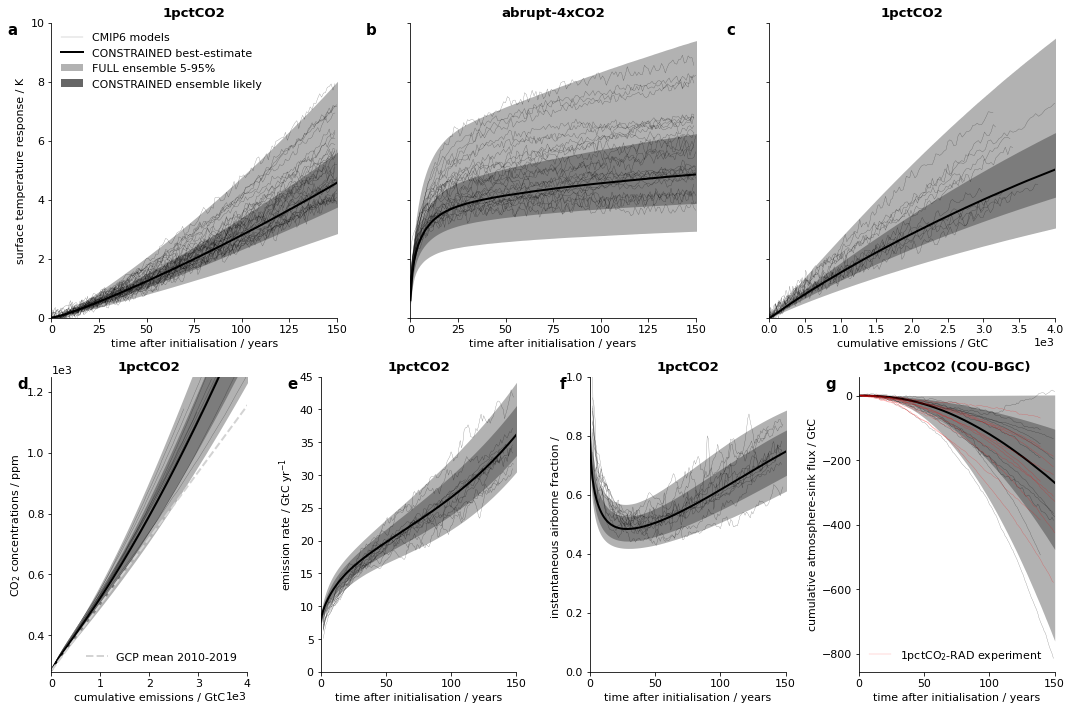

In [14]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(2,12)
ax1 = [fig.add_subplot(gs[0,4*i:4*(i+1)]) for i in np.arange(3)]
ax2 = [fig.add_subplot(gs[1,3*i:3*(i+1)]) for i in np.arange(4)]

# set quantile levels for each
FULL_quantiles = [0.05,0.95]
CONSTRAINED_quantiles = [0.166,0.833]

## 1pctCO2 response

ax = ax1[0]
ax.fill_between(FULL_DECK_runs['T'].index,*np.quantile(FULL_DECK_runs['T']['1pctCO2'],FULL_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.fill_between(CONSTRAINED_DECK_runs['T'].index,*np.quantile(CONSTRAINED_DECK_runs['T']['1pctCO2'],CONSTRAINED_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.plot(CONSTRAINED_DECK_runs['T'].index,np.quantile(CONSTRAINED_DECK_runs['T']['1pctCO2'],0.5,axis=1),color='k',lw=2)
### CMIP data
ax.plot(FULL_DECK_runs['T'].index,CMIP6_input_data['1pctCO2'].dropna(how='all',axis=1).iloc[:200],c='k',lw=0.3,alpha=0.5)

## abrupt-4xCO2 response

ax = ax1[1]
ax.fill_between(FULL_DECK_runs['T'].index,*np.quantile(FULL_DECK_runs['T']['abrupt-4xCO2'],FULL_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.fill_between(CONSTRAINED_DECK_runs['T'].index,*np.quantile(CONSTRAINED_DECK_runs['T']['abrupt-4xCO2'],CONSTRAINED_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.plot(CONSTRAINED_DECK_runs['T'].index,np.quantile(CONSTRAINED_DECK_runs['T']['abrupt-4xCO2'],0.5,axis=1),color='k',lw=2)
### CMIP data
ax.plot(FULL_DECK_runs['T'].index,CMIP6_input_data['abrupt-4xCO2'].dropna(how='all',axis=1).iloc[:200],c='k',lw=0.3,alpha=0.5)

## 1pctCO2 against emissions

ax = ax1[2]
ax.fill_between(FULL_1pct_T_on_E.index,*np.quantile(FULL_1pct_T_on_E,FULL_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.fill_between(CONSTRAINED_1pct_T_on_E.index,*np.quantile(CONSTRAINED_1pct_T_on_E,CONSTRAINED_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.plot(CONSTRAINED_1pct_T_on_E.index,np.quantile(CONSTRAINED_1pct_T_on_E,0.5,axis=1),color='k',lw=2)
### C4MIP data
C4MIP_1pct_T = C4MIP_input.xs('1pctCO2',axis=1,level=1).xs('tas',axis=1,level=1)
C4MIP_1pct_flux = C4MIP_input.xs('1pctCO2',axis=1,level=1).xs('flux',axis=1,level=1)
C4MIP_1pct_CO2 = C4MIP_input.xs('1pctCO2',axis=1,level=1).xs('CO2',axis=1,level=1)
C4MIP_1pct_CO2.loc[-1] = C4MIP_1pct_CO2.loc[0]/(1.01**0.5)
C4MIP_1pct_burden = C4MIP_1pct_CO2.sort_index().diff().dropna(how='all')
C4MIP_1pct_E = C4MIP_1pct_flux+C4MIP_1pct_burden/0.46888759388759393
ax.plot(C4MIP_1pct_E.iloc[:200].cumsum(),C4MIP_1pct_T.iloc[:200],c='k',lw=0.3,alpha=0.5)

## 1pctCO2 concs against cumulative emissions
ax = ax2[0]
ax.fill_betweenx(FULL_DECK_runs['C']['1pctCO2']['carbon_dioxide'],*np.quantile(FULL_DECK_runs['Emissions']['1pctCO2'].cumsum(),FULL_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.fill_betweenx(CONSTRAINED_DECK_runs['C']['1pctCO2']['carbon_dioxide'],*np.quantile(CONSTRAINED_DECK_runs['Emissions']['1pctCO2'].cumsum(),CONSTRAINED_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.plot(np.quantile(CONSTRAINED_DECK_runs['Emissions']['1pctCO2'].cumsum(),0.5,axis=1),CONSTRAINED_DECK_runs['C']['1pctCO2']['carbon_dioxide'],color='k',lw=2)
### C4MIP data
ax.plot(C4MIP_1pct_E.iloc[:200].cumsum(),C4MIP_1pct_CO2.sort_index().loc[0:],c='k',lw=0.3,alpha=0.5)
### GCP airbourne fraction
ax2[0].plot([0,5000],[284,284+5000*0.464*4.688876e-01],lw=2,ls='--',color='lightgrey')

## 1pctCO2 emission rate
ax = ax2[1]
ax.fill_between(FULL_DECK_runs['Emissions'].index,*np.quantile(FULL_DECK_runs['Emissions']['1pctCO2'],FULL_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.fill_between(CONSTRAINED_DECK_runs['Emissions'].index,*np.quantile(CONSTRAINED_DECK_runs['Emissions']['1pctCO2'],CONSTRAINED_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.plot(CONSTRAINED_DECK_runs['Emissions'].index,np.quantile(CONSTRAINED_DECK_runs['Emissions']['1pctCO2'],0.5,axis=1),color='k',lw=2)
## C4MIP data
ax.plot(C4MIP_1pct_E.index,C4MIP_1pct_E.rolling(5,center=True).mean(),c='k',lw=0.3,alpha=0.5)

## 1pct airbourne fraction
ax = ax2[2]
onepct_burden = (FULL_DECK_runs['C']['1pctCO2']-284)/0.46888759388759393
onepct_burden.loc[-1] = 0
onepct_atm_flux = onepct_burden.sort_index().diff().dropna().iloc[:,0]
FULL_1pct_af = FULL_DECK_runs['Emissions']['1pctCO2'].apply(lambda x: onepct_atm_flux/x)
CONSTRAINED_1pct_af = CONSTRAINED_DECK_runs['Emissions']['1pctCO2'].apply(lambda x: onepct_atm_flux/x)
ax.fill_between(FULL_1pct_af.index,*np.quantile(FULL_1pct_af,FULL_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.fill_between(CONSTRAINED_1pct_af.index,*np.quantile(CONSTRAINED_1pct_af,CONSTRAINED_quantiles,axis=1),alpha=0.3,color='k',lw=0)
ax.plot(CONSTRAINED_1pct_af.index,np.quantile(CONSTRAINED_1pct_af,0.5,axis=1),color='k',lw=2)
## C4MIP data
C4MIP_af = C4MIP_1pct_burden/(C4MIP_1pct_E*0.46888759388759393)
ax.plot(C4MIP_af.index,C4MIP_af.rolling(5,center=True).mean(),c='k',lw=0.3,alpha=0.5)

## effective 1pct-RAD
ax2[3].fill_between(np.arange(151),*np.quantile((FULL_1pct_E-BGC_FULL_1pct_E).loc[:150].cumsum(),[0.05,0.95],axis=1),lw=0,alpha=0.3,color='k')
ax2[3].fill_between(np.arange(151),*np.quantile((CONSTRAINED_1pct_E-BGC_CONSTRAINED_1pct_E).loc[:150].cumsum(),[0.17,0.83],axis=1),lw=0,alpha=0.3,color='k')
ax2[3].plot(np.arange(151),np.quantile((CONSTRAINED_1pct_E-BGC_CONSTRAINED_1pct_E).loc[:150].cumsum(),0.5,axis=1),color='k',lw=2)

ax2[3].plot(C4MIP_input.xs('1pctCO2',axis=1,level=1).xs('flux',axis=1,level=1).cumsum()-C4MIP_input.xs('1pctCO2-bgc',axis=1,level=1).xs('flux',axis=1,level=1).cumsum(),color='k',lw=0.3,alpha=0.5)
ax2[3].plot(C4MIP_input.xs('1pctCO2-rad',axis=1,level=1).xs('flux',axis=1,level=1).cumsum(),color='red',lw=0.3,alpha=0.5)

## labels & other layout specs

ax1[2].set_xlim(0,5000)
ax1[2].set_xlabel('cumulative emissions / GtC')
ax1[0].set_ylabel('surface temperature response / K')
[a.set_yticklabels([]) for a in ax1[1:]]
[a.set_xlabel('time after initialisation / years') for a in ax1[:-1]]
[a.set_xticks(np.arange(0,151,25)) for a in ax1[:-1]]
[a.set_xticklabels([str(x) for x in np.arange(0,151,25)]) for a in ax1[:-1]]
[ax1[i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','abrupt-4xCO2','1pctCO2'])]

sn.despine()

[ax2[i].set_ylabel(x) for i,x in enumerate(['CO$_2$ concentrations / ppm','emission rate / GtC yr$^{-1}$','instantaneous airborne fraction / ','cumulative atmosphere-sink flux / GtC'])]
[ax2[i].set_xlabel(x) for i,x in enumerate(['cumulative emissions / GtC','time after initialisation / years','time after initialisation / years','time after initialisation / years'])]
[ax2[i].set_title(x,fontweight='bold') for i,x in enumerate(['1pctCO2','1pctCO2','1pctCO2','1pctCO2 (COU-BGC)'])]

[a.set_xlim(0,150) for a in ax2[1:]]

ax1[0].plot([],[],color='k',lw=0.3,alpha=0.5,label='CMIP6 models')
ax1[0].fill_between([],[],color='k',lw=0,alpha=0.3,label='FULL ensemble 5-95%')
ax1[0].fill_between([],[],color='k',lw=0,alpha=0.6,label='CONSTRAINED ensemble likely')
ax1[0].plot([],[],color='k',lw=2,label='CONSTRAINED best-estimate')

ax2[0].plot([],[],lw=2,ls='--',color='lightgrey',label='GCP mean 2010-2019')

ax2[3].plot([],[],color='red',lw=0.3,alpha=0.5,label='1pctCO$_2$-RAD experiment')

[ax1[i].text(-0.12,1.00,x,va='top',ha='right',transform=ax1[i].transAxes,fontweight='bold',fontsize=15) for i,x in enumerate(['a','b','c'])]
[ax2[i].text(-0.12,1.00,x,va='top',ha='right',transform=ax2[i].transAxes,fontweight='bold',fontsize=15) for i,x in enumerate(['d','e','f','g'])]

[a.set_xlim(0,150) for a in ax1[:-1]+ax2[1:]]
[a.set_ylim(0,10) for a in ax1]
[a.set_xlim(0,4e3) for a in [ax1[-1],ax2[0]]]
ax2[0].set_ylim(280,1250)
ax2[1].set_ylim(0,45)
ax2[2].set_ylim(0,1)

plt.tight_layout()

ax1[0].legend(loc='upper left',handles = ax1[0].get_legend_handles_labels()[0][-4:],labels = ax1[0].get_legend_handles_labels()[1][-4:])
ax2[0].legend(loc='lower right')
ax2[3].legend(loc='lower left')

[fig.savefig('../../docs/manuscript/figures/Fig8.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

### Print out some TCRE values for the text

 Worth noting that the TCRE holds the same sensitivity to choice of observational dataset used to compute the global warming index as the TCR. First we carry out the most straightforward calculation (temperature over total cumulative emissions for various emission levels):
 $$
 \text{TCRE}=\frac{T(t)}{\sum_{s=0}^{t}{E(s)}}
 $$

In [15]:
print('TCRE at various emision levels (K / 1000 GtC)')
CONSTRAINED_1pct_T_on_E.loc[[1000,2000,3000,4000,5000]].apply(lambda x: 1000*x/x.name,axis=1).T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[:,[4,5,6,7,8]].round(2)

TCRE at various emision levels (K / 1000 GtC)


,5%,16.6%,50%,83.3%,95%
1000,1.11,1.27,1.53,1.86,2.13
2000,1.02,1.17,1.42,1.75,2.03
3000,0.95,1.09,1.33,1.65,1.94
4000,0.89,1.02,1.25,1.57,1.85
5000,0.83,0.96,1.18,1.48,1.76


TCRE curvature estimation - this time we use a linear regression over blocks of 1000 GtC (ie. from 0 to 1000 GtC, 1000 to 2000 GtC and so on).

In [16]:
pd.concat([CONSTRAINED_1pct_T_on_E.loc[x-1000:x].apply(lambda x: 1000*sp.stats.linregress(x.index,x).slope).T.describe(percentiles=[.05,.166,.5,.833,.95]).T.iloc[[4,5,6,7,8]].round(2) for x in [1000,2000,3000,4000,5000]],axis=1,keys=[1000,2000,3000,4000,5000]).T

,5%,16.6%,50%,83.3%,95%
1000,1.12,1.28,1.55,1.89,2.17
2000,0.91,1.05,1.31,1.65,1.97
3000,0.78,0.91,1.15,1.47,1.80
4000,0.68,0.80,1.01,1.31,1.62
5000,0.60,0.70,0.89,1.15,1.43
